## Utility

In [2]:
import sys
import csv
import re
import pandas as pd
import numpy as np
import torch.nn.functional as fn
import torch as th


def load_module(entity_file, relation_file, entity_emb_file, rel_emb_file):
  # Get drugname/disease name to entity ID mappings
  entity_map = {}
  entity_id_map = {}
  relation_map = {}
  nodetype_ids={}
  ntypePattern = re.compile(r"^(.*)::")

  with open(entity_file, newline='', encoding='utf-8') as csvfile:
      reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id','name'])
      for row_val in reader:
          ntype = ntypePattern.match(row_val['name']).group(1)
          iid = int(row_val['id'])
          entity_map[row_val['name']] = iid
          entity_id_map[iid] = row_val['name']
          if ntype not in nodetype_ids:
              nodetype_ids[ntype]=[]
          nodetype_ids[ntype].append(iid)
          
  with open(relation_file, newline='', encoding='utf-8') as csvfile:
      reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id','name'])
      for row_val in reader:
          relation_map[row_val['name']] = int(row_val['id'])

  # Load embeddings
  entity_emb = np.load(entity_emb_file)
  rel_emb = np.load(rel_emb_file)

  return {
      "entity_map": entity_map,
      "entity_id_map": entity_id_map,
      "relation_map": relation_map,
      "nodetype_ids": nodetype_ids,
      "entity_embedding": entity_emb,
      "rel_embedding": rel_emb
  }

/opt/conda/envs/biomedgps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def distance(head, tail):
  score = head - tail
  return th.norm(score, p=2, dim=-1)


def transE_l2(head, rel, tail, gamma=12.0):
  score = head + rel - tail
  return gamma - th.norm(score, p=2, dim=-1)


def query(model_map, relations: list[str], source_id: str, reverse_prediction: bool = True):
  """
  relations: ['Hetionet::CtD::Compound:Disease', 'GNBR::T::Compound:Disease', 'DRUGBANK::treats::Compound:Disease']
  source_id: MESH:D015673
  """
  if reverse_prediction:
    target, source = relations[0].split('::')[2].split(':')
  else:
    source, target = relations[0].split('::')[2].split(':')

  relation_map = model_map.get("relation_map")
  relation_ids = [relation_map[relation] for relation in relations]
  relation_ids = th.tensor(relation_ids)
  rel_emb = model_map.get("rel_embedding")
  relations_embs = [th.tensor(rel_emb[rid]) for rid in relation_ids]

  sources = [source + "::" + source_id]

  entity_map = model_map.get("entity_map")
  source_ids = [entity_map[source]
          for source in sources if source in entity_map]
  source_ids = th.tensor(source_ids)

  nodetype_ids = model_map.get("nodetype_ids")
  target_ids = nodetype_ids[target]
  target_ids = th.tensor(target_ids)

  entity_emb = model_map.get("entity_embedding")
  target_emb = th.tensor(entity_emb[target_ids])

  return {
    "relation_ids": relation_ids,
    "relations_embeddings": relations_embs,
    "source_ids": source_ids,
    "target_ids": target_ids,
    "target_embedding": target_emb,
    "relations": relations
  }


In [4]:
# one for each
def relation_each(model_map, results, reverse_prediction=True, topk=100):
  allpd = pd.DataFrame()
  relations_embs = results.get("relations_embeddings")
  source_ids = results.get("source_ids")
  entity_emb = model_map.get("entity_embedding")
  target_emb = results.get("target_embedding")
  relations = results.get("relations")
  target_ids = results.get("target_ids")
  entity_id_map = model_map.get("entity_id_map")

  for rid in range(len(relations_embs)):
    relation_embs = relations_embs[rid]
    for source_id in source_ids:
      source_emb = th.tensor(entity_emb[source_id])
      if reverse_prediction:
        score = fn.logsigmoid(transE_l2(target_emb, relation_embs, source_emb))
      else:
        score = fn.logsigmoid(transE_l2(source_emb, relation_embs, target_emb))

      newpd= pd.DataFrame({
          "relation": relations[rid],
          "source_id": int(source_id),
          "target_id": target_ids.tolist(),
          "score": score.tolist()
      })

      allpd=pd.concat([allpd,newpd])
      # scores_per_sources.append(score)
      # dids.append(target_ids)

  topkpd = allpd.sort_values("score", ascending=False).head(n=topk)
  topkpd["source"] = [entity_id_map[i] for i in topkpd["source_id"]]
  topkpd["target"] = [entity_id_map[i] for i in topkpd["target_id"]]
  return topkpd


In [5]:
# average source_id
def relation_ave(model_map, results, reverse_prediction=True, topk=100):
    relations_embs = results.get("relations_embeddings")
    entity_emb = model_map.get("entity_embedding")
    source_ids = results.get("source_ids")
    target_ids = results.get("target_ids")
    target_emb = results.get("target_embedding")
    entity_id_map = model_map.get("entity_id_map")
    relations = results.get("relations")
    allpd = pd.DataFrame()
    for rid in range(len(relations_embs)):
        relation_embs = relations_embs[rid]

        source_emb = th.mean(th.tensor(entity_emb[source_ids]),0)
        if reverse_prediction:
            score = fn.logsigmoid(transE_l2(target_emb, relation_embs, source_emb))
        else:
            score = fn.logsigmoid(transE_l2(source_emb, relation_embs, target_emb))
        newpd= pd.DataFrame({
            "relation": relations[rid],
            "target_id": target_ids.tolist(),
            "score": score.tolist()
        })

        allpd=pd.concat([allpd,newpd])
        # scores_per_sources.append(score)
        # dids.append(target_ids)

    topkpd=allpd.sort_values("score",ascending=False).head(n=topk)
    topkpd["target"] = [entity_id_map[i] for i in topkpd["target_id"]] 
    return topkpd

## DRKG

In [6]:
import os

dataset = 'drkg-hsdn'
working_dir = f'./{dataset}'
idx = 0
model_dir = os.path.join(working_dir, f'models/TransE_l2_{dataset}_{idx}')
entity_idmap_file = os.path.join(working_dir, 'data/train/entities.tsv')
relation_idmap_file = os.path.join(working_dir, 'data/train/relations.tsv')
entity_emb_file = os.path.join(model_dir, f'{dataset}_TransE_l2_entity.npy')
rel_emb_file = os.path.join(model_dir, f'{dataset}_TransE_l2_relation.npy')
entity_relation_map = load_module(entity_idmap_file, relation_idmap_file, entity_emb_file, rel_emb_file)

In [7]:
entity_relation_map.get("relation_map").keys()

dict_keys(['STRING::BINDING::Gene:Gene', 'STRING::OTHER::Gene:Gene', 'DRUGBANK::ddi-interactor-in::Compound:Compound', 'Hetionet::AeG::Anatomy:Gene', 'STRING::CATALYSIS::Gene:Gene', 'Hetionet::GiG::Gene:Gene', 'INTACT::PHYSICAL ASSOCIATION::Gene:Gene', 'HSDN::has_symptom:Disease:Symptom', 'Hetionet::GpCC::Gene:CellularComponent', 'STRING::REACTION::Gene:Gene', 'GNBR::E+::Gene:Gene', 'GNBR::L::Gene:Disease', 'GNBR::T::Compound:Disease', 'GNBR::E::Compound:Gene', 'DRUGBANK::target::Compound:Gene', 'Hetionet::AuG::Anatomy:Gene', 'INTACT::ASSOCIATION::Gene:Gene', 'bioarx::DrugHumGen:Compound:Gene', 'GNBR::Pa::Compound:Disease', 'Hetionet::GpBP::Gene:BiologicalProcess', 'bioarx::HumGenHumGen:Gene:Gene', 'GNBR::Q::Gene:Gene', 'Hetionet::GpPW::Gene:Pathway', 'STRING::ACTIVATION::Gene:Gene', 'Hetionet::DaG::Disease:Gene', 'Hetionet::GpMF::Gene:MolecularFunction', 'Hetionet::Gr>G::Gene:Gene', 'Hetionet::CcSE::Compound:SideEffect', 'STRING::INHIBITION::Gene:Gene', 'GNBR::Rg::Gene:Gene', 'Hetione

In [13]:
entities = entity_relation_map.get('entity_map').keys()
print(list(entities)[0])
drugs = [entity for entity in entities if entity.startswith('Compound::DrugBank:DB')]
len(drugs)

Gene::ENTREZ:9388


10551

In [16]:
relations = ['Hetionet::CtD::Compound:Disease', 'GNBR::T::Compound:Disease', 'DRUGBANK::treats::Compound:Disease']
source_id = "MESH:D015673"

results = query(entity_relation_map, relations, source_id)
topkpd = relation_each(entity_relation_map, results, topk=10551)
topkpd_ave = relation_ave(entity_relation_map, results, topk=10551)
topkpd, topkpd_ave

(                                 relation  source_id  target_id     score  \
 2934            GNBR::T::Compound:Disease      10388      13551 -0.100722   
 3871            GNBR::T::Compound:Disease      10388      20835 -0.133700   
 3047            GNBR::T::Compound:Disease      10388      14206 -0.171202   
 4170            GNBR::T::Compound:Disease      10388      23434 -0.186087   
 15592           GNBR::T::Compound:Disease      10388      75481 -0.202335   
 ...                                   ...        ...        ...       ...   
 12068           GNBR::T::Compound:Disease      10388      63891 -2.296925   
 5779            GNBR::T::Compound:Disease      10388      35945 -2.297035   
 22405           GNBR::T::Compound:Disease      10388      94125 -2.297062   
 2995            GNBR::T::Compound:Disease      10388      13921 -2.297151   
 10914  DRUGBANK::treats::Compound:Disease      10388      59753 -2.297461   
 
                       source                      target  
 2

/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

<Axes: xlabel='score', ylabel='Count'>

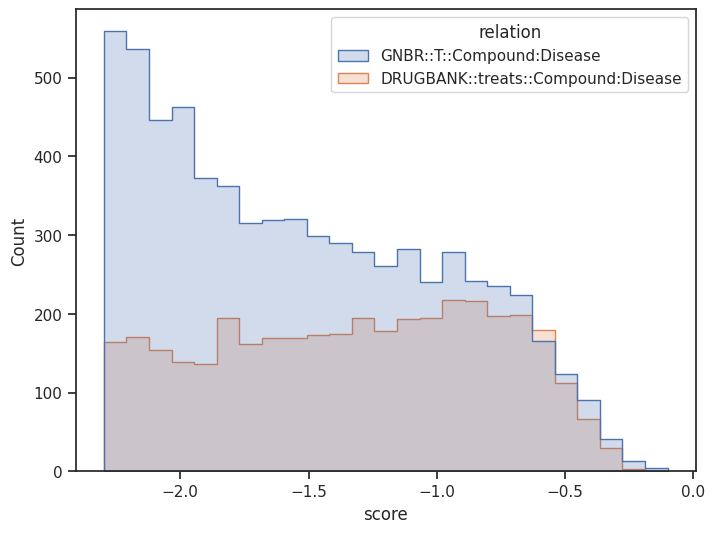

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks')
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x='score', hue='relation', data=topkpd, element='step', ax=ax)

In [19]:
rootdir = os.path.dirname(os.getcwd())
entity_file = os.path.join(rootdir, 'graph_data/entities.tsv')
entities = pd.read_csv(entity_file, sep='\t', dtype=str)
entities.head()

,id,name,label,resource,description,synonyms,pmids,taxid,xrefs
0,SYMP:0000149,obsolete sudden onset of severe chills,Symptom,SymptomOntology,NaN,NaN,NaN,NaN,NaN
1,SYMP:0000259,dry hacking cough,Symptom,SymptomOntology,A dry cough that is characterized by a rough a...,NaN,NaN,NaN,NaN
2,SYMP:0000729,pulmonary consolidation,Symptom,SymptomOntology,A respiratory system and chest symptom that is...,NaN,NaN,NaN,NaN
3,SYMP:0000746,enanthem,Symptom,SymptomOntology,A skin and integumentary tissue symptom that i...,NaN,NaN,NaN,NaN
4,SYMP:0000412,anxiety,Symptom,SymptomOntology,A neurological and physiological symptom that ...,NaN,NaN,NaN,NaN


In [23]:
# Join the topkpd with the entity dataframe
df = entities.copy()
df["node_id"] = entities["label"] + "::" + entities["id"]
merged = topkpd.merge(df, left_on='target', right_on='node_id')
merged.to_csv(os.path.join(model_dir, f"mecfs-output.tsv"), sep="\t", index=False)
merged.head()

,relation,source_id,target_id,score,source,target,id,name,label,resource,description,synonyms,pmids,taxid,xrefs,node_id
0,GNBR::T::Compound:Disease,10388,14206,-0.171202,Disease::MESH:D015673,Compound::DrugBank:DB01065,DrugBank:DB01065,MELATONIN,Compound,DrugBank,A member of the class of acetamides that is a...,Mela-T|Melapure|Vivitas|N-(2-(5-Methoxy-1H-Ind...,8290600|16678784|18212404|18485664,NaN,CHEMBL:CHEMBL45|DrugBank:DB01065|CHEBI:16796|M...,Compound::DrugBank:DB01065
1,DRUGBANK::treats::Compound:Disease,10388,14206,-0.316080,Disease::MESH:D015673,Compound::DrugBank:DB01065,DrugBank:DB01065,MELATONIN,Compound,DrugBank,A member of the class of acetamides that is a...,Mela-T|Melapure|Vivitas|N-(2-(5-Methoxy-1H-Ind...,8290600|16678784|18212404|18485664,NaN,CHEMBL:CHEMBL45|DrugBank:DB01065|CHEBI:16796|M...,Compound::DrugBank:DB01065
2,GNBR::T::Compound:Disease,10388,23434,-0.186087,Disease::MESH:D015673,Compound::MESH:D002331,MESH:D002331,Carnitine,Compound,DrugBank,A constituent of STRIATED MUSCLE and LIVER. It...,Levocarnitine|L Carnitine|L-Carnitine|1-Propan...,NaN,NaN,MESH:D002331|UMLS:C0007258|UMLS:C0087163|UMLS:...,Compound::MESH:D002331
3,DRUGBANK::treats::Compound:Disease,10388,23434,-1.142684,Disease::MESH:D015673,Compound::MESH:D002331,MESH:D002331,Carnitine,Compound,DrugBank,A constituent of STRIATED MUSCLE and LIVER. It...,Levocarnitine|L Carnitine|L-Carnitine|1-Propan...,NaN,NaN,MESH:D002331|UMLS:C0007258|UMLS:C0087163|UMLS:...,Compound::MESH:D002331
4,GNBR::T::Compound:Disease,10388,75481,-0.202335,Disease::MESH:D015673,Compound::MESH:C116917,MESH:C116917,acylcarnitine,Compound,DrugBank,NaN,NaN,NaN,NaN,UMLS:C0368608|MESH:C116917,Compound::MESH:C116917


In [ ]:
root_dir = os.path.dirname(os.getcwd())
expected_drugs = pd.read_csv(os.path.join(root_dir, "benchmarks/deduplicated_drugs.txt"), sep='\t')
formatted_expected_drug_ids = [f'Compound::DrugBank:{drug}' for drug in expected_drugs['DrugBankID']]
expected_drugs["FormattedDrugID"] = formatted_expected_drug_ids
expected_drugs, formatted_expected_drug_ids

## BioMedGPS

### Statistics of ME/CFS & LongCOVID's relations

In [9]:
import os
root_dir = os.path.dirname(os.getcwd())
relations = pd.read_csv(os.path.join(root_dir, "graph_data", "relations.tsv"), sep="\t")
relations

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [12]:
# Long COVID
MESH_ID = "MESH:D000077299"
MONDO_ID = "MONDO:0100233"

In [13]:
# ME/CFS
MESH_ID = "MESH:D015673"
MONDO_ID = "MONDO:0005404"

sub_mesh_relations = relations[(relations["source_id"] == MESH_ID) | (relations["target_id"] == MESH_ID)]
sub_mondo_relations = relations[(relations["source_id"] == MONDO_ID) | (relations["target_id"] == MONDO_ID)]
print(len(sub_mesh_relations), len(sub_mondo_relations))

print(sub_mesh_relations.head())
print(sub_mondo_relations.head())

0 66
Empty DataFrame
Columns: [raw_source_id, raw_target_id, raw_source_type, raw_target_type, relation_type, resource, pmids, key_sentence, source_id, source_type, target_id, target_type, source_target]
Index: []
         raw_source_id  raw_target_id raw_source_type raw_target_type  \
4027066  MONDO:0005404  MONDO:0002254         Disease         Disease   
4071751  MONDO:0005404  MONDO:0005218         Disease         Disease   
4080187  MONDO:0002254  MONDO:0005404         Disease         Disease   
4080188  MONDO:0005218  MONDO:0005404         Disease         Disease   
4080189  MONDO:0008856  MONDO:0005404         Disease         Disease   

                                 relation_type resource  pmids  key_sentence  \
4027066  PrimeKG::parent-child:Disease:Disease  PrimeKG    NaN           NaN   
4071751  PrimeKG::parent-child:Disease:Disease  PrimeKG    NaN           NaN   
4080187  PrimeKG::parent-child:Disease:Disease  PrimeKG    NaN           NaN   
4080188  PrimeKG::parent-ch

### Predict

In [6]:
import os

dataset = 'biomedgps'
working_dir = f'./{dataset}'
idx = 0
model_dir = os.path.join(working_dir, f'models/TransE_l2_{dataset}_{idx}')
entity_idmap_file = os.path.join(working_dir, 'data/train/entities.tsv')
relation_idmap_file = os.path.join(working_dir, 'data/train/relations.tsv')
entity_emb_file = os.path.join(model_dir, f'{dataset}_TransE_l2_entity.npy')
rel_emb_file = os.path.join(model_dir, f'{dataset}_TransE_l2_relation.npy')
entity_relation_map = load_module(entity_idmap_file, relation_idmap_file, entity_emb_file, rel_emb_file)

### ME/CFS

In [7]:
relations = ['Hetionet::CtD::Compound:Disease', 'GNBR::T::Compound:Disease', 'DRUGBANK::treats::Compound:Disease']
source_id = "MONDO:0005404"

results = query(entity_relation_map, relations, source_id)
topkpd = relation_each(entity_relation_map, results, topk=10551)
topkpd_ave = relation_ave(entity_relation_map, results, topk=10551)
topkpd, topkpd_ave

(                            relation  source_id  target_id      score  \
 200        GNBR::T::Compound:Disease      29536       3019  -1.582331   
 107        GNBR::T::Compound:Disease      29536       1816  -1.691878   
 346        GNBR::T::Compound:Disease      29536       6206  -1.746902   
 410        GNBR::T::Compound:Disease      29536       8151  -1.804843   
 255        GNBR::T::Compound:Disease      29536       3994  -1.904112   
 ..                               ...        ...        ...        ...   
 616  Hetionet::CtD::Compound:Disease      29536      28736 -11.401516   
 650  Hetionet::CtD::Compound:Disease      29536      45456 -11.422467   
 708  Hetionet::CtD::Compound:Disease      29536      89193 -11.478988   
 581  Hetionet::CtD::Compound:Disease      29536      19291 -11.602646   
 701  Hetionet::CtD::Compound:Disease      29536      79262 -12.005384   
 
                      source                      target  
 200  Disease::MONDO:0005404  Compound::DrugBank:DB

In [10]:
expected_drugs = pd.read_csv(os.path.join(root_dir, "benchmarks/deduplicated_drugs.txt"), sep='\t')
formatted_expected_drug_ids = [f'Compound::DrugBank:{drug}' for drug in expected_drugs['DrugBankID']]
expected_drugs["FormattedDrugID"] = formatted_expected_drug_ids
filtered_topkpd = topkpd[topkpd['target'].isin(formatted_expected_drug_ids)]
filtered_topkpd

,relation,source_id,target_id,score,source,target
200,GNBR::T::Compound:Disease,29536,3019,-1.582331,Disease::MONDO:0005404,Compound::DrugBank:DB00635
107,GNBR::T::Compound:Disease,29536,1816,-1.691878,Disease::MONDO:0005404,Compound::DrugBank:DB01234
346,GNBR::T::Compound:Disease,29536,6206,-1.746902,Disease::MONDO:0005404,Compound::DrugBank:DB00741
410,GNBR::T::Compound:Disease,29536,8151,-1.804843,Disease::MONDO:0005404,Compound::DrugBank:DB00959
255,GNBR::T::Compound:Disease,29536,3994,-1.904112,Disease::MONDO:0005404,Compound::DrugBank:DB00443
...,...,...,...,...,...,...
616,Hetionet::CtD::Compound:Disease,29536,28736,-11.401516,Disease::MONDO:0005404,Compound::DrugBank:DB07278
650,Hetionet::CtD::Compound:Disease,29536,45456,-11.422467,Disease::MONDO:0005404,Compound::DrugBank:DB15902
708,Hetionet::CtD::Compound:Disease,29536,89193,-11.478988,Disease::MONDO:0005404,Compound::DrugBank:DB14645
581,Hetionet::CtD::Compound:Disease,29536,19291,-11.602646,Disease::MONDO:0005404,Compound::DrugBank:DB03896


/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/envs/biomedgps/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

<Axes: xlabel='score', ylabel='Count'>

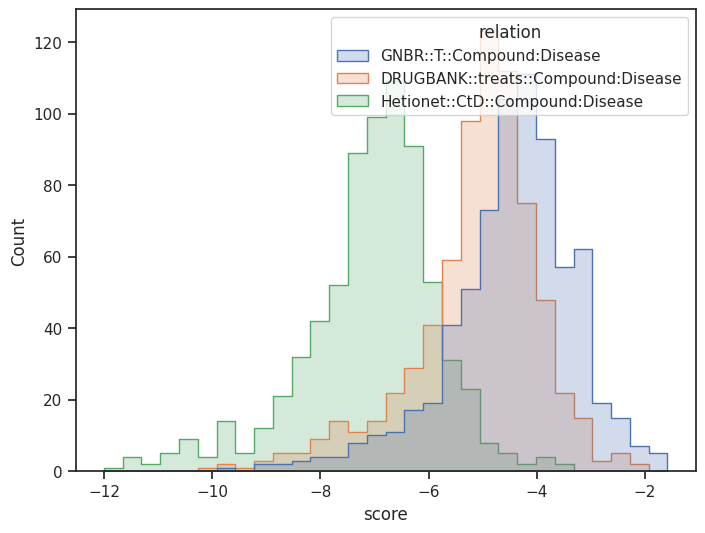

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks')
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x='score', hue='relation', data=filtered_topkpd, element='step', ax=ax)

In [17]:
# Show the score distribution with plotly
import plotly.express as px
fig = px.histogram(filtered_topkpd, x="score", nbins=100)
fig.show()

# Show me all drugs with score >= -3
print(filtered_topkpd[filtered_topkpd['score'] >= -3].shape)

filtered_topkpd["DrugName"] = [expected_drugs[expected_drugs['FormattedDrugID'] == drug_id]['DrugName'].values[0] for drug_id in filtered_topkpd['target']]
filtered_topkpd.to_csv(os.path.join(root_dir, "models/biomedgps/output.tsv"), sep="\t")

(65, 6)


### Long COVID

In [18]:
relations = ['Hetionet::CtD::Compound:Disease', 'GNBR::T::Compound:Disease', 'DRUGBANK::treats::Compound:Disease']
source_id = "MONDO:0100233"

results = query(entity_relation_map, relations, source_id)
topkpd = relation_each(entity_relation_map, results, topk=10551)
topkpd_ave = relation_ave(entity_relation_map, results, topk=10551)
topkpd, topkpd_ave

(                               relation  source_id  target_id      score  \
 527           GNBR::T::Compound:Disease      76281      13919  -4.902023   
 254           GNBR::T::Compound:Disease      76281       3933  -5.076385   
 35            GNBR::T::Compound:Disease      76281        574  -5.111142   
 421           GNBR::T::Compound:Disease      76281       8546  -5.158375   
 254  DRUGBANK::treats::Compound:Disease      76281       3933  -5.158604   
 ..                                  ...        ...        ...        ...   
 668     Hetionet::CtD::Compound:Disease      76281      52870 -12.255265   
 688     Hetionet::CtD::Compound:Disease      76281      67477 -12.349639   
 710           GNBR::T::Compound:Disease      76281      93046 -12.751887   
 710  DRUGBANK::treats::Compound:Disease      76281      93046 -12.780122   
 710     Hetionet::CtD::Compound:Disease      76281      93046 -13.515121   
 
                      source                      target  
 527  Disease::

In [19]:
expected_drugs = pd.read_csv(os.path.join(root_dir, "benchmarks/deduplicated_drugs.txt"), sep='\t')
formatted_expected_drug_ids = [f'Compound::DrugBank:{drug}' for drug in expected_drugs['DrugBankID']]
expected_drugs["FormattedDrugID"] = formatted_expected_drug_ids
filtered_topkpd = topkpd[topkpd['target'].isin(formatted_expected_drug_ids)]
filtered_topkpd

,relation,source_id,target_id,score,source,target
527,GNBR::T::Compound:Disease,76281,13919,-4.902023,Disease::MONDO:0100233,Compound::DrugBank:DB09140
254,GNBR::T::Compound:Disease,76281,3933,-5.076385,Disease::MONDO:0100233,Compound::DrugBank:DB00571
35,GNBR::T::Compound:Disease,76281,574,-5.111142,Disease::MONDO:0100233,Compound::DrugBank:DB00126
421,GNBR::T::Compound:Disease,76281,8546,-5.158375,Disease::MONDO:0100233,Compound::DrugBank:DB00331
254,DRUGBANK::treats::Compound:Disease,76281,3933,-5.158604,Disease::MONDO:0100233,Compound::DrugBank:DB00571
...,...,...,...,...,...,...
668,Hetionet::CtD::Compound:Disease,76281,52870,-12.255265,Disease::MONDO:0100233,Compound::DrugBank:DB16346
688,Hetionet::CtD::Compound:Disease,76281,67477,-12.349639,Disease::MONDO:0100233,Compound::DrugBank:DB14973
710,GNBR::T::Compound:Disease,76281,93046,-12.751887,Disease::MONDO:0100233,Compound::DrugBank:DB04998
710,DRUGBANK::treats::Compound:Disease,76281,93046,-12.780122,Disease::MONDO:0100233,Compound::DrugBank:DB04998


In [20]:
# Show the score distribution with plotly
import plotly.express as px
fig = px.histogram(filtered_topkpd, x="score", nbins=100)
fig.show()

# Show me all drugs with score >= -3
print(filtered_topkpd[filtered_topkpd['score'] >= -3].shape)

filtered_topkpd["DrugName"] = [expected_drugs[expected_drugs['FormattedDrugID'] == drug_id]['DrugName'].values[0] for drug_id in filtered_topkpd['target']]
filtered_topkpd.to_csv(os.path.join(root_dir, "models/biomedgps/long-covid-output.tsv"), sep="\t")

(0, 6)
